In [1]:
#!sudo apt-get update --fix-missing
#!sudo apt install graphviz -y
#!pip install pydot optuna

In [138]:
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow import keras
import optuna

%matplotlib inline
%config InlineBackend.figure_format = 'jpg'

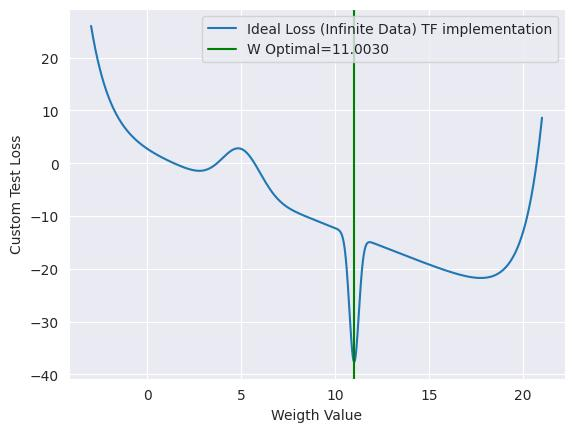

In [139]:
def G(x,mean, variance):
     return np.exp(-np.square(x-mean)/2*variance)/(np.sqrt(2*np.pi*variance))

def custom_loss(x):
    y=np.exp(-x) +0.09*np.exp(-15+x) -0.1*np.abs(x+17) -200*G(x,8,10) + 10*G(x,15,1)
    return y

def custom_loss_tf(x):
    y=tf.math.exp(-x) - 1.5*x
    y = tf.add(y,tf.multiply(0.09,tf.math.exp(tf.add(-15.0,x))))
    y  = tf.subtract(y,tf.multiply(-0.1,tf.abs(tf.add(x,17.0))))
    y  = tf.subtract(y,tf.multiply(15.,tfd.Normal(loc=11., scale=0.25).prob(x)))
    y  = tf.add(y,tf.multiply(20.,tfd.Normal(loc=5., scale=1.).prob(x)))
    return y

N=10000
x=np.linspace(-3,21,N)
y=custom_loss_tf(tf.constant(x,dtype=tf.float32))
y2=custom_loss(x)
TRUE_W = x[np.argmin(y)]
plt.figure()
w=20

for _ in range(1):
    noisy=y+np.random.normal(0, 0.25, N)
    #noisy = signal.filtfilt(1/(w*np.ones(w)), 1, noisy)
    #plt.plot(x,noisy,c='r',alpha=0.75,label='Batch Loss')
plt.plot(x,y,label='Ideal Loss (Infinite Data) TF implementation')
#plt.plot(x,y2,label='Ideal Loss (Infinite Data)',c='r')
plt.axvline(TRUE_W,c='g',label='W Optimal=%0.4f'%TRUE_W)
plt.xlabel('Weigth Value')
plt.ylabel('Custom Test Loss')
plt.legend()
plt.show()

In [142]:
class LastSample(keras.metrics.Metric):
    def __init__(self, name='sample', **kwargs):
        super().__init__(name=name, **kwargs)
        self.sample = self.add_variable(shape=(),initializer='zeros',name='sample')
    def update_state(self, y):
        self.sample.assign(y)
    def result(self):
        return self.sample

class CustomModel(keras.Model):
    def __init__(self,loss_func, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker = LastSample(name="loss")
        self.w_metric = LastSample(name="weight")
        self.momentum = LastSample(name="momentum")
        self.velocity = LastSample(name="velocity")
        self.loss_func=loss_func

    def train_step(self, data):
        trainable_vars = self.trainable_variables
        self.w_metric.update_state(tf.squeeze(trainable_vars[0]))
        with tf.GradientTape() as tape:
            loss = self.loss_func(tf.squeeze(trainable_vars[0]))
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_tracker.update_state(tf.squeeze(loss))

        #print(self.optimizer.variables()[1])
        self.momentum.update_state(tf.squeeze(self.optimizer.variables()[1]))
        self.velocity.update_state(tf.squeeze(self.optimizer.variables()[2]))

        return {"loss": self.loss_tracker.result(), "weight": self.w_metric.result(), "momentum":self.momentum.result(), "velocity":self.velocity.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.w_metric, self.momentum, self.velocity]


def run(optimizer,seed=0,loss_func=None):
    initalizer=tf.keras.initializers.GlorotUniform(seed)
    inputs = keras.Input(shape=(1,))
    outputs = keras.layers.Dense(1,use_bias=False,kernel_initializer=initalizer)(inputs)
    model = CustomModel(loss_func,inputs, outputs)
    xtrain = np.random.random((1, 1))*0
    ytrain = xtrain*TRUE_W
    model.compile(optimizer=optimizer,run_eagerly=False)
    history = model.fit(xtrain, ytrain, epochs=100,verbose=0,batch_size=128)
    return history

/tmp/ipykernel_238025/1328969923.py:4: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self.sample = self.add_variable(shape=(),initializer='zeros',name='sample')
/tmp/ipykernel_238025/1034153047.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4*2,4,i*4*2+k+1)


b1=0.9 b2=0.999 epsilon=1e-08
-1.4514458179473877
b1=0.5 b2=0.999 epsilon=1e-08
-1.4515180587768555
(-1.4515180587768555, 0.5, 0.999, 1e-08)


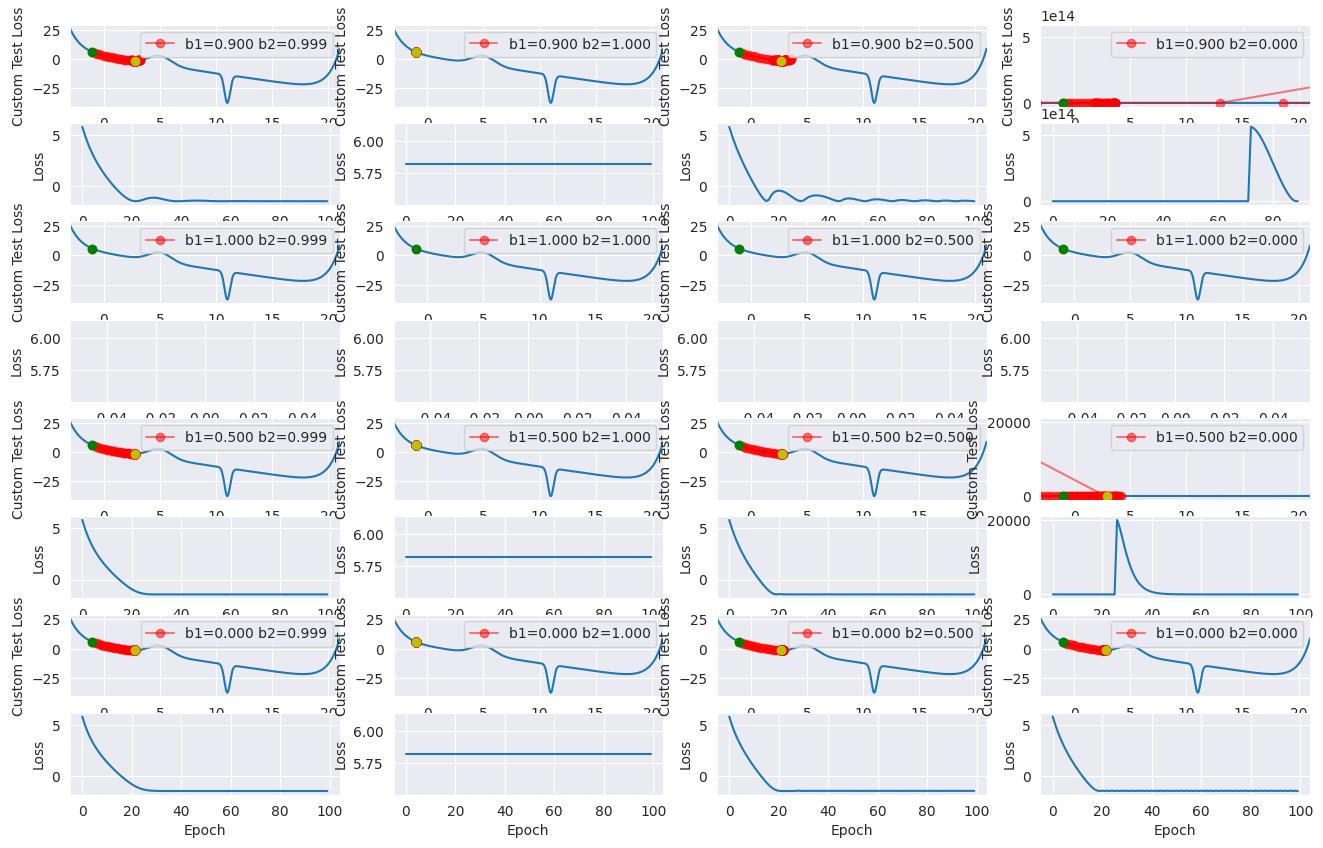

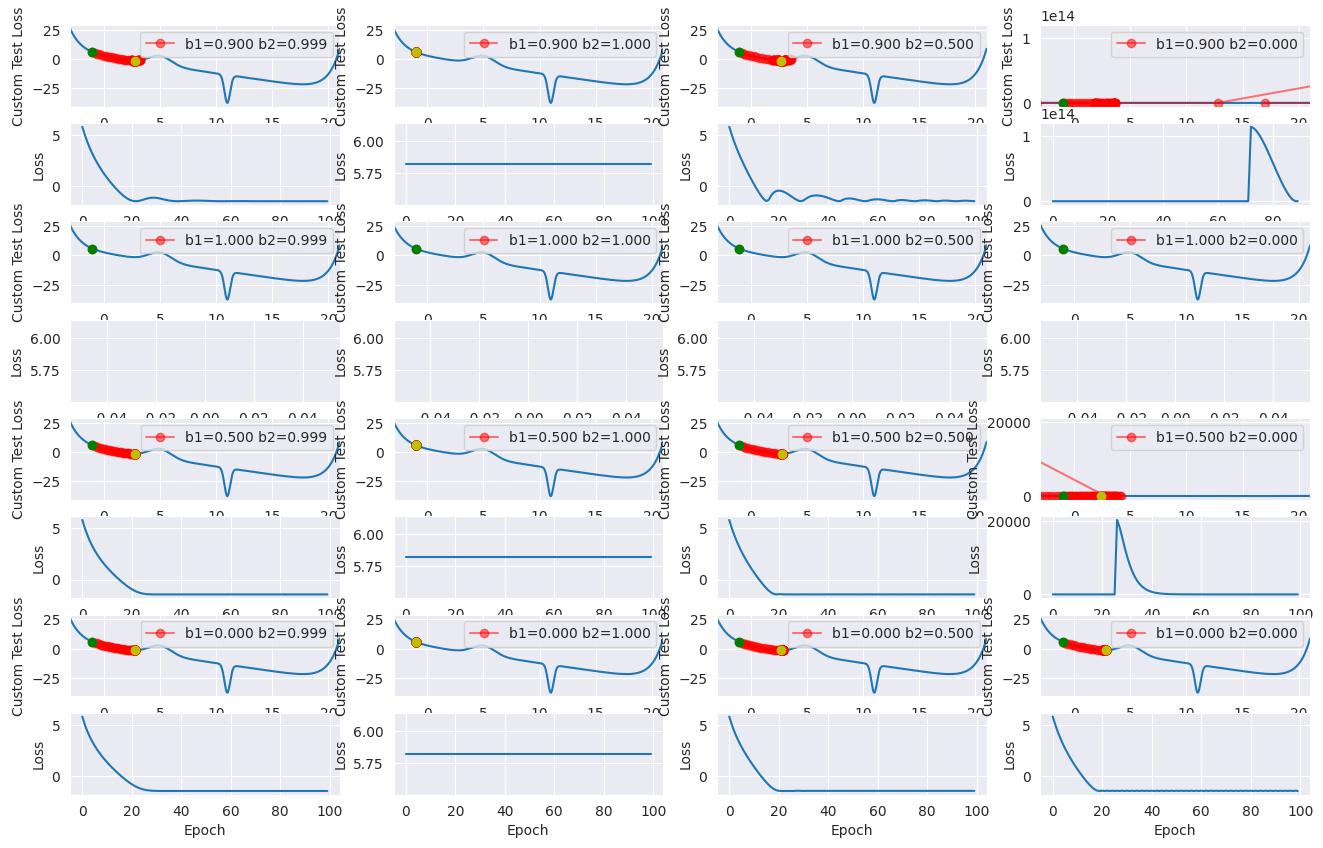

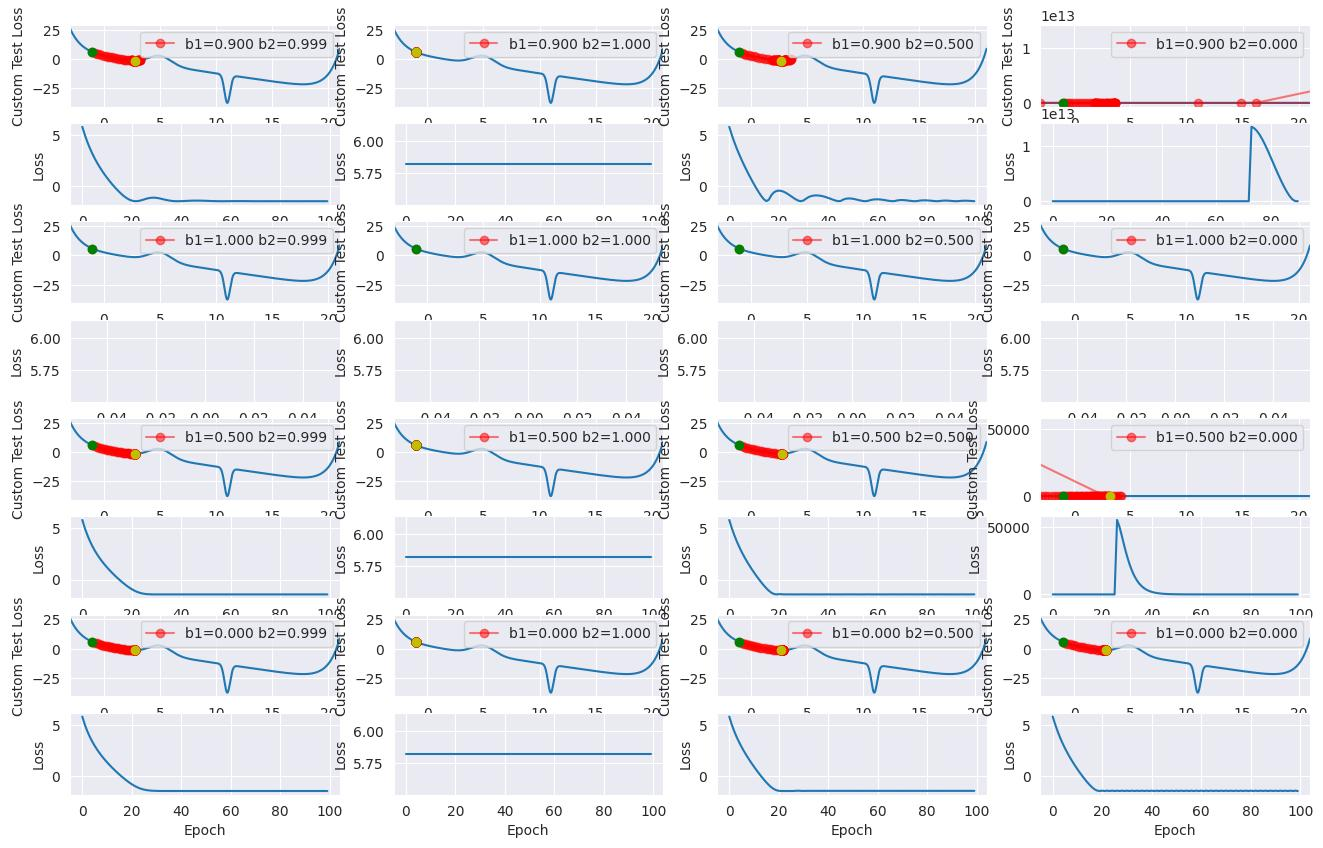

In [144]:
best=(np.inf,None,None,None)
for _,epsilon in enumerate([1e-8,1e-7,1e-6]):
    plt.figure(figsize=(16, 10))
    losses={}
    momentum={}
    velocity={}
    count=0
    for i,beta_1 in enumerate([0.9, 1.,  0.5 ,0]):
        for k,beta_2 in enumerate([0.999, 1., 0.5 ,0]):
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.2,beta_1=beta_1, beta_2=beta_2,epsilon=epsilon)
            history = run(optimizer=optimizer,loss_func=custom_loss_tf)
            if i==0 and k==0:
                plt.title("Epsilon %0.4f"%epsilon)
            plt.subplot(4*2,4,i*4*2+k+1)
            plt.plot(x,y)
            plt.plot(history.history['weight'],history.history['loss'],c='r',marker='o',label='b1=%0.3f b2=%0.3f'%(beta_1,beta_2),alpha=0.5)
            plt.plot(history.history['weight'][0],history.history['loss'][0],c='g',marker='o')
            plt.plot(history.history['weight'][-1],history.history['loss'][-1],c='y',marker='o')
            plt.xlim([np.min(x),np.max(x)])
            plt.xlabel('Weigth Value')
            plt.ylabel('Custom Test Loss')
            plt.legend()

            plt.subplot(4*2,4,i*4*2+k+1+4)
            plt.plot(history.history['loss'])
            #plt.ylim([np.min(y),np.max(y)])
            plt.ylabel("Loss")
            plt.xlabel("Epoch")
            if history.history['loss'][-1]<best[0]:
                print("b1=%s b2=%s epsilon=%s"%(beta_1,beta_2,epsilon))
                print(history.history['loss'][-1])
                best=(history.history['loss'][-1],beta_1,beta_2,epsilon)
            losses[count]=history.history['loss']
            momentum[count]=history.history['momentum']
            velocity[count]=history.history['velocity']

            count+=1
print(best)

In [145]:
def get_params(trial):
    params = {"lr": trial.suggest_float("lr", 1e-3, 1),
              "beta_1": trial.suggest_float("beta_1",0.5,0.99),
              "beta_2": trial.suggest_categorical("beta_2",[0,0.1]),
              "epsilon":trial.suggest_categorical("epsilon",[1e-8,1e-7,1e-6,1e-5]),
              "seed":trial.suggest_categorical("seed",[0,1,2,3,4,5,6,7,8,9]),
              }
    return params

def get_objective():
    def objective(trial):
        params = get_params(trial)
        optimizer=tf.keras.optimizers.Adam(learning_rate=params['lr'],beta_1=params['beta_1'],beta_2=params['beta_2'],epsilon=params['epsilon'])
        history = run(optimizer=optimizer,seed=params['seed'],loss_func=custom_loss_tf)
        score=history.history['loss'][-1]
        score = 30 if np.isnan(score) else score
        return score
    return objective

def optuna_tuner(optuna_trials=100):
    n_startup_trials=50
    sampler = optuna.samplers.TPESampler(seed=10, n_startup_trials=n_startup_trials,consider_endpoints=True,multivariate=True)
    study = optuna.create_study(sampler=sampler, direction="minimize")
    objective = get_objective()
    study.optimize(objective, n_trials=optuna_trials)
    trial = study.best_trial
    print("**"*50 + " Finished Optimizing")
    print("Number of finished trials: ", len(study.trials))
    print("  Value: {}".format(trial.value))
    print("Best  Params: %s" % str(trial.params))
    results=trial.params.copy()
    return results

best_params = optuna_tuner(optuna_trials=100)

/usr/local/lib/python3.8/dist-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-06-11 16:41:38,897] A new study created in memory with name: no-name-40f2aa1c-ff12-4b7c-b5f6-14c5c8c41f89
/tmp/ipykernel_238025/1328969923.py:4: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self.sample = self.add_variable(shape=(),initializer='zeros',name='sample')
[I 2024-06-11 16:41:39,384] Trial 0 finished with value: -1.0613170862197876 and parameters: {'lr': 0.7715493226234792, 'beta_1': 0.5101684551861068, 'beta_2': 0.1, 'epsilon': 1e-05, 'seed': 3}. Best is trial 0 with value: -1.0613170862197876.
[I 2024-06-11 16:41:39,874] Trial 1 finished with value: 30.0 and parameters: {'lr': 0.9178563483904305, 'beta_1': 0.8501421338648684, 'beta_2': 0, 'epsilon': 1e-07, 'seed': 6}. 

**************************************************************************************************** Finished Optimizing
Number of finished trials:  100
  Value: -32.2309455871582
Best  Params: {'lr': 0.344019424394633, 'beta_1': 0.8077679923825423, 'beta_2': 0, 'epsilon': 1e-07, 'seed': 0}


/tmp/ipykernel_238025/1328969923.py:4: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self.sample = self.add_variable(shape=(),initializer='zeros',name='sample')


-32.2309455871582


Text(0.5, 0, 'Epoch')

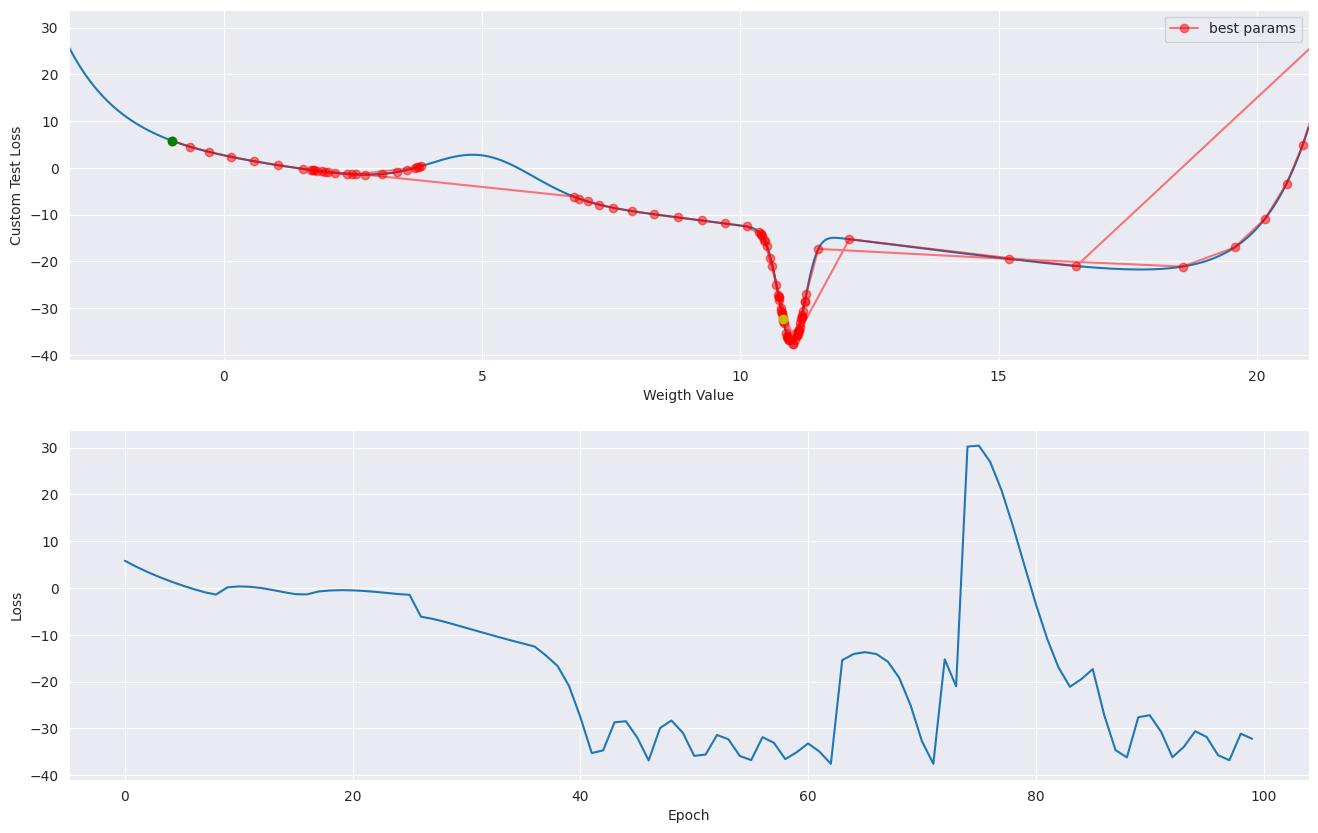

In [146]:
plt.figure(figsize=(16, 10))
history = run(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['lr'],beta_1=best_params['beta_1'],
                                                 beta_2=best_params['beta_2'],epsilon=best_params['epsilon']),
                                                seed=best_params['seed'],
                                                loss_func=custom_loss_tf)
print(history.history['loss'][-1])
plt.subplot(2,1,1)
plt.plot(x,y)
plt.plot(history.history['weight'],history.history['loss'],c='r',marker='o',label='best params'%(best_params),alpha=0.5)
plt.plot(history.history['weight'][0],history.history['loss'][0],c='g',marker='o')
plt.plot(history.history['weight'][-1],history.history['loss'][-1],c='y',marker='o')
plt.xlim([np.min(x),np.max(x)])
plt.xlabel('Weigth Value')
plt.ylabel('Custom Test Loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
#plt.ylim([np.min(y),np.max(y)])
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [147]:
def get_params(trial):
    params = {"lr": trial.suggest_float("lr", 1e-3, 1),
              "beta_1": trial.suggest_float("beta_1",0.5,0.99),
              "beta_2": trial.suggest_categorical("beta_2",[0,0.1]),
              "epsilon":trial.suggest_categorical("epsilon",[1e-8,1e-7,1e-6,1e-5]),
              "seed":trial.suggest_categorical("seed",[0,1,2,3,4,5,6,7,8,9]),
              }
    return params

def get_objective():
    def objective(trial):
        params = get_params(trial)
        learning_rate=tf.keras.optimizers.schedules.CosineDecayRestarts(params['lr'],10)
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=params['beta_1'],beta_2=params['beta_2'],epsilon=params['epsilon'])
        history = run(optimizer=optimizer,loss_func=custom_loss_tf)
        score=history.history['loss'][-1]
        score = 30 if np.isnan(score) else score
        return score
    return objective

def optuna_tuner(optuna_trials=100):
    n_startup_trials=50
    sampler = optuna.samplers.TPESampler(seed=10, n_startup_trials=n_startup_trials,consider_endpoints=True,multivariate=True)
    study = optuna.create_study(sampler=sampler, direction="minimize")
    objective = get_objective()
    study.optimize(objective, n_trials=optuna_trials)
    trial = study.best_trial
    print("**"*50 + " Finished Optimizing")
    print("Number of finished trials: ", len(study.trials))
    print("  Value: {}".format(trial.value))
    print("Best  Params: %s" % str(trial.params))
    results=trial.params.copy()
    return results

best_params = optuna_tuner(optuna_trials=100)

/usr/local/lib/python3.8/dist-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-06-11 16:42:36,799] A new study created in memory with name: no-name-c103fc35-4be4-4f42-95e6-6e0bd7f4b416
/tmp/ipykernel_238025/1328969923.py:4: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self.sample = self.add_variable(shape=(),initializer='zeros',name='sample')
[I 2024-06-11 16:42:37,332] Trial 0 finished with value: -1.4050447940826416 and parameters: {'lr': 0.7715493226234792, 'beta_1': 0.5101684551861068, 'beta_2': 0.1, 'epsilon': 1e-05, 'seed': 3}. Best is trial 0 with value: -1.4050447940826416.
[I 2024-06-11 16:42:37,903] Trial 1 finished with value: 30.0 and parameters: {'lr': 0.9178563483904305, 'beta_1': 0.8501421338648684, 'beta_2': 0, 'epsilon': 1e-07, 'seed': 6}. 

**************************************************************************************************** Finished Optimizing
Number of finished trials:  100
  Value: -36.80474853515625
Best  Params: {'lr': 0.4637489790151759, 'beta_1': 0.8015293261694655, 'beta_2': 0, 'epsilon': 1e-08, 'seed': 3}


In [148]:
plt.figure(figsize=(16, 10))
learning_rate=tf.keras.optimizers.schedules.CosineDecayRestarts(best_params['lr'],10)
history = run(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=best_params['beta_1'],
                                                 beta_2=best_params['beta_2'],epsilon=best_params['epsilon']),seed=best_params['seed'],loss_func=custom_loss_tf)
print(best_params)
print(history.history['loss'][-1])
plt.subplot(2,1,1)
plt.plot(x,y)
plt.plot(history.history['weight'],history.history['loss'],c='r',marker='o',label='best params'%(best_params),alpha=0.5)
plt.plot(history.history['weight'][0],history.history['loss'][0],c='g',marker='o')
plt.plot(history.history['weight'][-1],history.history['loss'][-1],c='y',marker='o')
plt.xlim([np.min(x),np.max(x)])
plt.xlabel('Weigth Value')
plt.ylabel('Custom Test Loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
#plt.ylim([np.min(y),np.max(y)])
plt.ylabel("Loss")
plt.xlabel("Epoch")

/tmp/ipykernel_238025/1328969923.py:4: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self.sample = self.add_variable(shape=(),initializer='zeros',name='sample')


TypeError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/tmp/ipykernel_238025/1328969923.py", line 23, in train_step
        loss = self.loss_func(tf.squeeze(trainable_vars[0]))

    TypeError: 'NoneType' object is not callable


<Figure size 1600x1000 with 0 Axes>

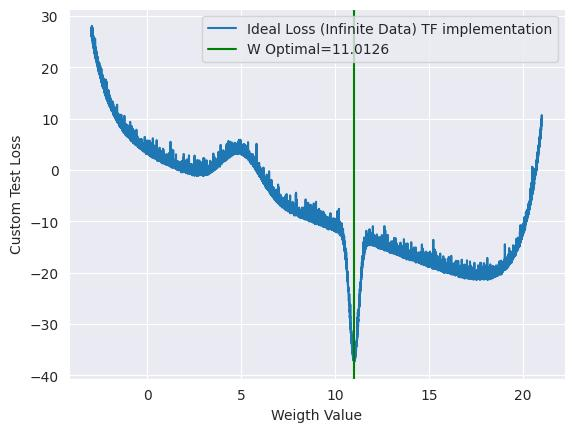

In [150]:
#Loss with Noise
def custom_loss_tf2(x):
    y=tf.math.exp(-x) - 1.5*x
    y = tf.add(y,tf.multiply(0.09,tf.math.exp(tf.add(-15.0,x))))
    y  = tf.subtract(y,tf.multiply(-0.1,tf.abs(tf.add(x,17.0))))
    y  = tf.subtract(y,tf.multiply(15.,tfd.Normal(loc=11., scale=0.25).prob(x)))
    y  = tf.add(y,tf.multiply(20.,tfd.Normal(loc=5., scale=1.).prob(x)))
    y  = tf.add(y,tfd.LogNormal(loc=0., scale=0.5).sample(sample_shape=y.shape,seed=0))
    return y

N=10000
x=np.linspace(-3,21,N)
y=custom_loss_tf2(tf.constant(x,dtype=tf.float32))
TRUE_W = x[np.argmin(y)]
plt.figure()
w=20
plt.plot(x,y,label='Ideal Loss (Infinite Data) TF implementation')
plt.axvline(TRUE_W,c='g',label='W Optimal=%0.4f'%TRUE_W)
plt.xlabel('Weigth Value')
plt.ylabel('Custom Test Loss')
plt.legend()
plt.show()


/tmp/ipykernel_238025/1328969923.py:4: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self.sample = self.add_variable(shape=(),initializer='zeros',name='sample')
/tmp/ipykernel_238025/2562185885.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4*2,4,i*4*2+k+1)


b1=0.9 b2=0.999 epsilon=1e-08
-0.5832017660140991
b1=0.5 b2=0.999 epsilon=1e-08
-0.5832740068435669
(-0.5832740068435669, 0.5, 0.999, 1e-08)


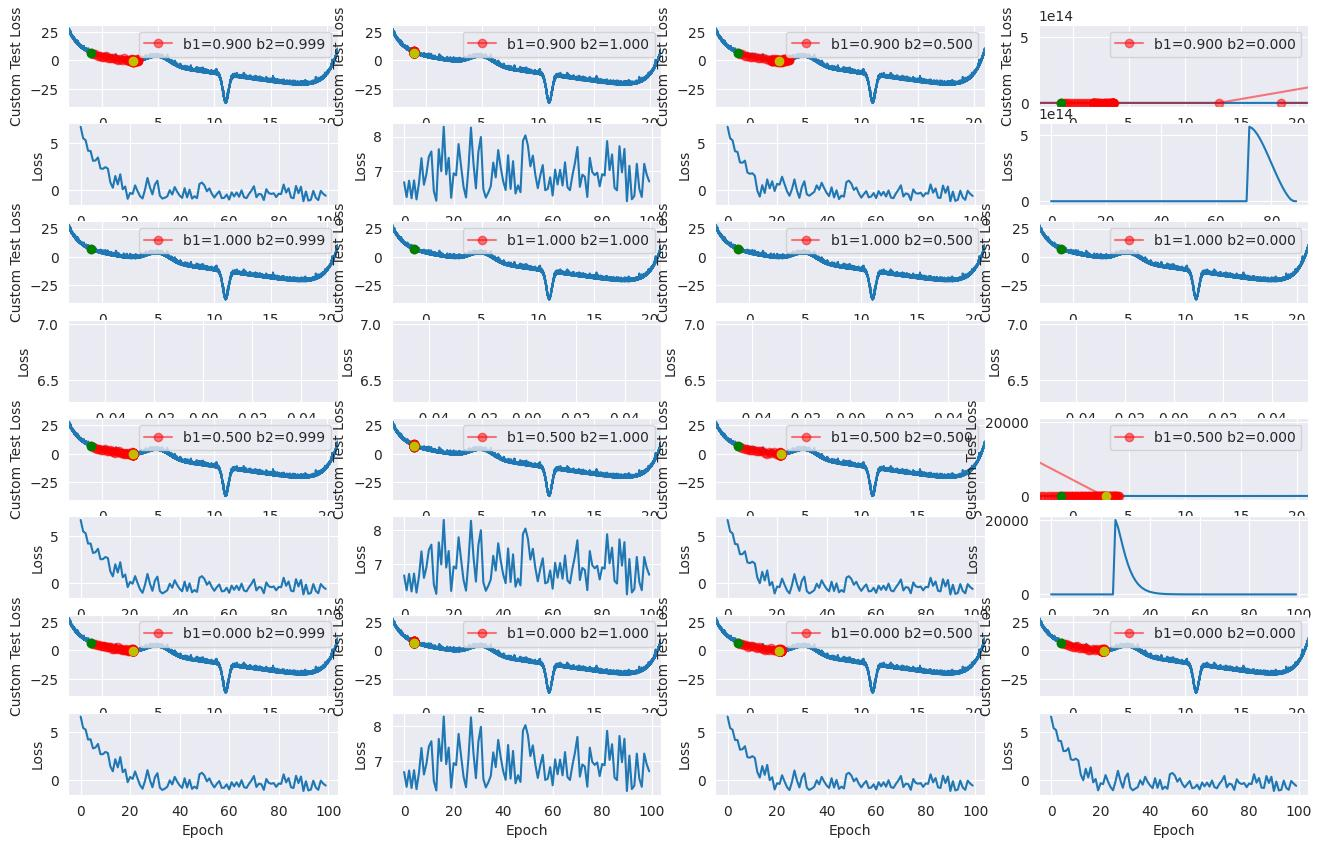

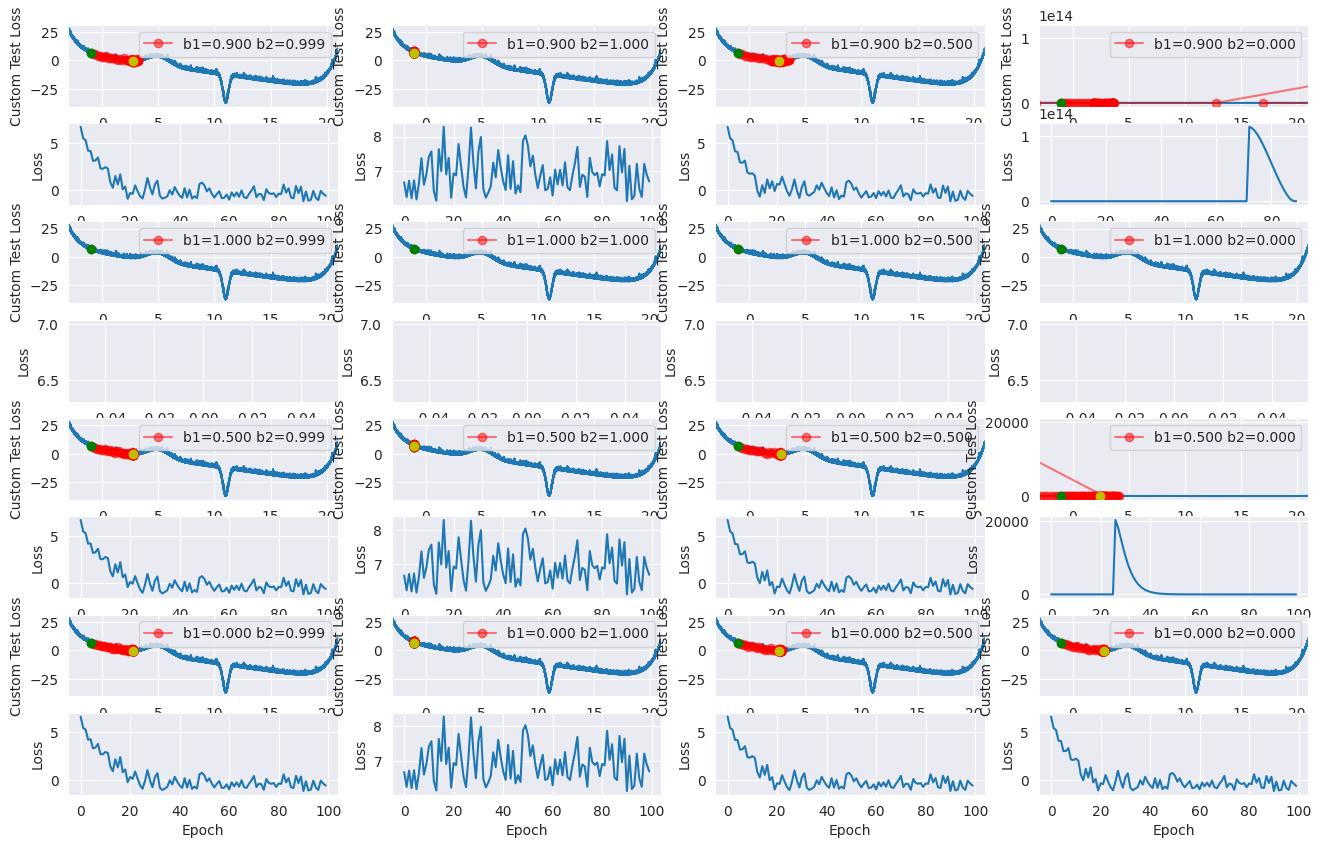

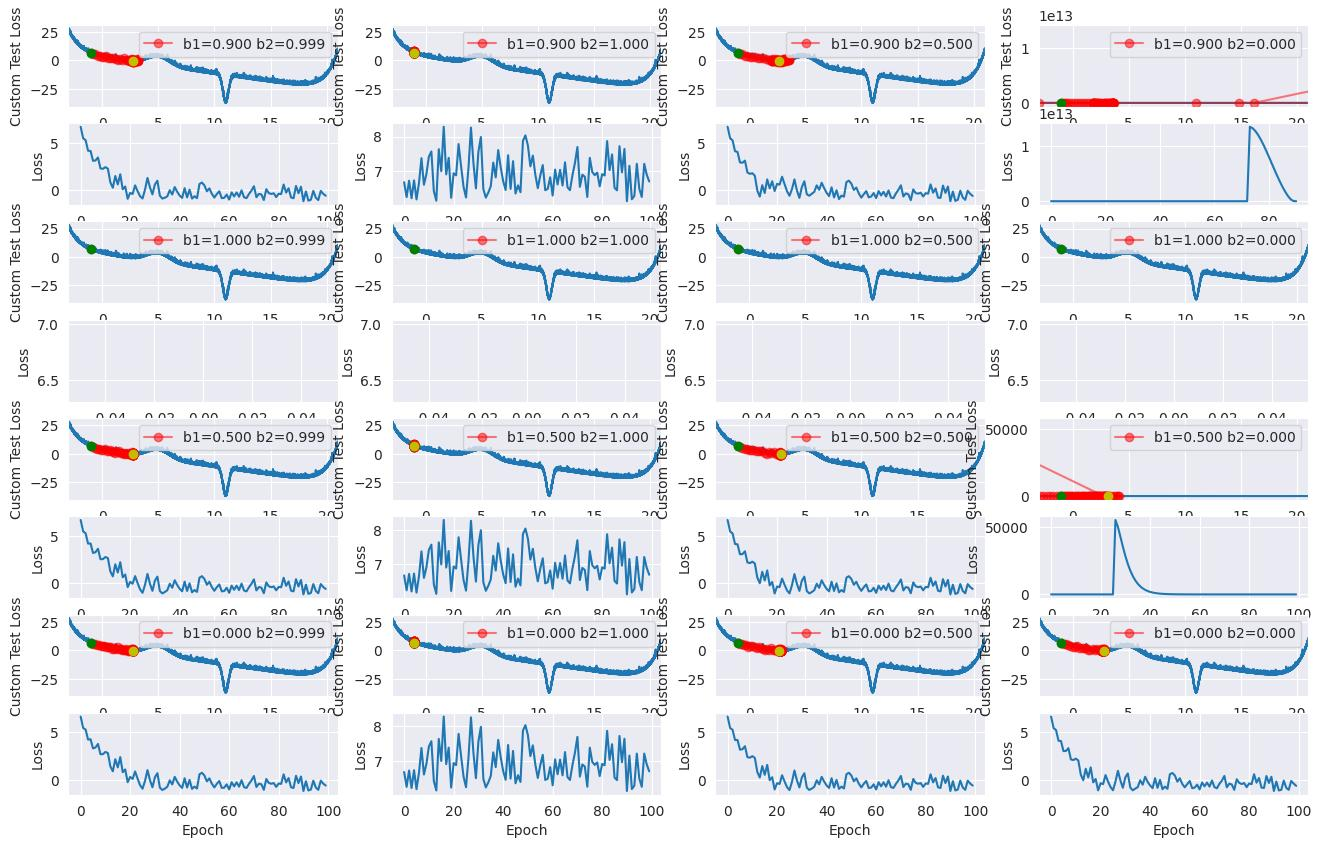

In [151]:
best=(np.inf,None,None,None)
for _,epsilon in enumerate([1e-8,1e-7,1e-6]):
    plt.figure(figsize=(16, 10))
    for i,beta_1 in enumerate([0.9, 1.,  0.5 ,0]):
        for k,beta_2 in enumerate([0.999, 1., 0.5 ,0]):
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.2,beta_1=beta_1, beta_2=beta_2,epsilon=epsilon)
            history = run(optimizer=optimizer,loss_func=custom_loss_tf2)
            if i==0 and k==0:
                plt.title("Epsilon %0.4f"%epsilon)
            plt.subplot(4*2,4,i*4*2+k+1)
            plt.plot(x,y)
            plt.plot(history.history['weight'],history.history['loss'],c='r',marker='o',label='b1=%0.3f b2=%0.3f'%(beta_1,beta_2),alpha=0.5)
            plt.plot(history.history['weight'][0],history.history['loss'][0],c='g',marker='o')
            plt.plot(history.history['weight'][-1],history.history['loss'][-1],c='y',marker='o')
            plt.xlim([np.min(x),np.max(x)])
            plt.xlabel('Weigth Value')
            plt.ylabel('Custom Test Loss')
            plt.legend()

            plt.subplot(4*2,4,i*4*2+k+1+4)
            plt.plot(history.history['loss'])
            #plt.ylim([np.min(y),np.max(y)])
            plt.ylabel("Loss")
            plt.xlabel("Epoch")
            if history.history['loss'][-1]<best[0]:
                print("b1=%s b2=%s epsilon=%s"%(beta_1,beta_2,epsilon))
                print(history.history['loss'][-1])
                best=(history.history['loss'][-1],beta_1,beta_2,epsilon)
print(best)

In [152]:
def get_objective():
    def objective(trial):
        params = get_params(trial)
        optimizer=tf.keras.optimizers.Adam(learning_rate=params['lr'],beta_1=params['beta_1'],beta_2=params['beta_2'],epsilon=params['epsilon'])
        history = run(optimizer=optimizer,seed=params['seed'],loss_func=custom_loss_tf2)
        score=history.history['loss'][-1]
        score = 30 if np.isnan(score) else score
        return score
    return objective

def optuna_tuner(optuna_trials=100):
    n_startup_trials=50
    sampler = optuna.samplers.TPESampler(seed=10, n_startup_trials=n_startup_trials,consider_endpoints=True,multivariate=True)
    study = optuna.create_study(sampler=sampler, direction="minimize")
    objective = get_objective()
    study.optimize(objective, n_trials=optuna_trials)
    trial = study.best_trial
    print("**"*50 + " Finished Optimizing")
    print("Number of finished trials: ", len(study.trials))
    print("  Value: {}".format(trial.value))
    print("Best  Params: %s" % str(trial.params))
    results=trial.params.copy()
    return results

best_params = optuna_tuner(optuna_trials=100)

/usr/local/lib/python3.8/dist-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-06-11 18:25:36,069] A new study created in memory with name: no-name-c56fc0cf-dc5c-4111-9c0c-ee1c4d5d805c
/tmp/ipykernel_238025/1328969923.py:4: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self.sample = self.add_variable(shape=(),initializer='zeros',name='sample')
[I 2024-06-11 18:25:36,661] Trial 0 finished with value: -0.19307303428649902 and parameters: {'lr': 0.7715493226234792, 'beta_1': 0.5101684551861068, 'beta_2': 0.1, 'epsilon': 1e-05, 'seed': 3}. Best is trial 0 with value: -0.19307303428649902.
[I 2024-06-11 18:25:37,231] Trial 1 finished with value: 30.0 and parameters: {'lr': 0.9178563483904305, 'beta_1': 0.8501421338648684, 'beta_2': 0, 'epsilon': 1e-07, 'seed': 6}

**************************************************************************************************** Finished Optimizing
Number of finished trials:  100
  Value: -31.362701416015625
Best  Params: {'lr': 0.344019424394633, 'beta_1': 0.8077679923825423, 'beta_2': 0, 'epsilon': 1e-07, 'seed': 0}


/tmp/ipykernel_238025/1328969923.py:4: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self.sample = self.add_variable(shape=(),initializer='zeros',name='sample')


-31.362701416015625


Text(0.5, 0, 'Epoch')

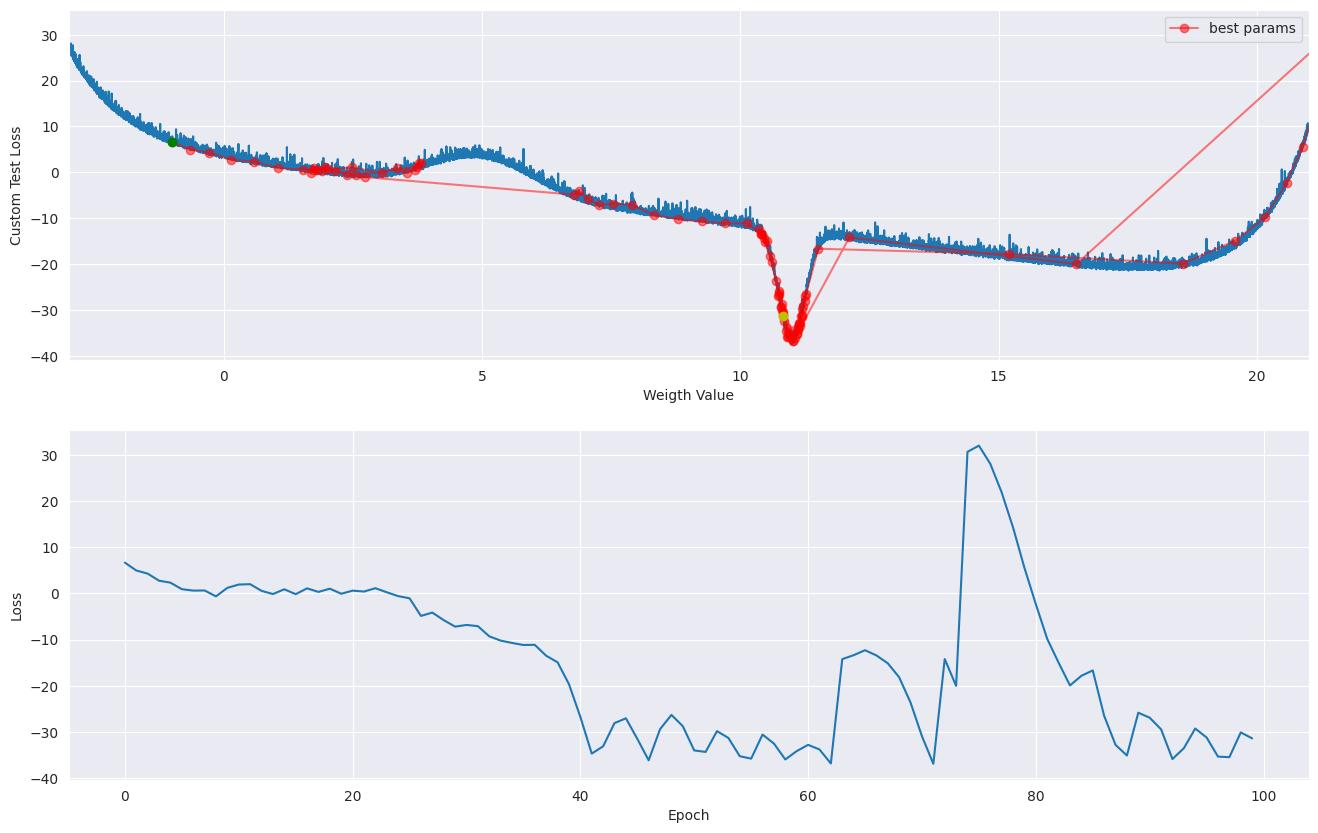

In [154]:
plt.figure(figsize=(16, 10))
history = run(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['lr'],beta_1=best_params['beta_1'],
                                                 beta_2=best_params['beta_2'],epsilon=best_params['epsilon']),
                                                seed=best_params['seed'],
                                                loss_func=custom_loss_tf2)
print(history.history['loss'][-1])
plt.subplot(2,1,1)
plt.plot(x,y)
plt.plot(history.history['weight'],history.history['loss'],c='r',marker='o',label='best params'%(best_params),alpha=0.5)
plt.plot(history.history['weight'][0],history.history['loss'][0],c='g',marker='o')
plt.plot(history.history['weight'][-1],history.history['loss'][-1],c='y',marker='o')
plt.xlim([np.min(x),np.max(x)])
plt.xlabel('Weigth Value')
plt.ylabel('Custom Test Loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
#plt.ylim([np.min(y),np.max(y)])
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [167]:
def get_params(trial):
    params = {"lr": trial.suggest_float("lr", 1e-3, 1),
              "beta_1": trial.suggest_float("beta_1",0.5,0.99),
              "beta_2": trial.suggest_categorical("beta_2",[0,0.1,0.5,0.999]),
              "epsilon":trial.suggest_categorical("epsilon",[1e-8,1e-7,1e-6,1e-5]),
              "seed":trial.suggest_categorical("seed",[0,1,2,3,4,5,6,7,8,9]),
              }
    return params

def get_objective():
    def objective(trial):
        params = get_params(trial)
        learning_rate=tf.keras.optimizers.schedules.CosineDecayRestarts(params['lr'],2)
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=params['beta_1'],beta_2=params['beta_2'],epsilon=params['epsilon'])
        history = run(optimizer=optimizer,loss_func=custom_loss_tf2)
        score=history.history['loss'][-1]
        score = 30 if np.isnan(score) else score
        return score
    return objective

def optuna_tuner(optuna_trials=100):
    n_startup_trials=50
    sampler = optuna.samplers.TPESampler(seed=10, n_startup_trials=n_startup_trials,consider_endpoints=True,multivariate=True)
    study = optuna.create_study(sampler=sampler, direction="minimize")
    objective = get_objective()
    study.optimize(objective, n_trials=optuna_trials)
    trial = study.best_trial
    print("**"*50 + " Finished Optimizing")
    print("Number of finished trials: ", len(study.trials))
    print("  Value: {}".format(trial.value))
    print("Best  Params: %s" % str(trial.params))
    results=trial.params.copy()
    return results

best_params = optuna_tuner(optuna_trials=100)

/usr/local/lib/python3.8/dist-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-06-11 18:57:51,021] A new study created in memory with name: no-name-08457e0c-ddc9-4541-bfb4-7cd07ea9a5e4
/tmp/ipykernel_238025/1328969923.py:4: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self.sample = self.add_variable(shape=(),initializer='zeros',name='sample')
[I 2024-06-11 18:57:51,583] Trial 0 finished with value: -0.522991418838501 and parameters: {'lr': 0.7715493226234792, 'beta_1': 0.5101684551861068, 'beta_2': 0.1, 'epsilon': 1e-07, 'seed': 1}. Best is trial 0 with value: -0.522991418838501.
[I 2024-06-11 18:57:52,160] Trial 1 finished with value: -0.5718519687652588 and parameters: {'lr': 0.54300182364325, 'beta_1': 0.5696633233247482, 'beta_2': 0.1, 'epsilon': 1e-06,

**************************************************************************************************** Finished Optimizing
Number of finished trials:  100
  Value: -36.769046783447266
Best  Params: {'lr': 0.8871769570152, 'beta_1': 0.535195527321946, 'beta_2': 0, 'epsilon': 1e-05, 'seed': 4}


/tmp/ipykernel_238025/1328969923.py:4: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self.sample = self.add_variable(shape=(),initializer='zeros',name='sample')


{'lr': 0.8871769570152, 'beta_1': 0.535195527321946, 'beta_2': 0, 'epsilon': 1e-05, 'seed': 4}
nan


Text(0.5, 0, 'Epoch')

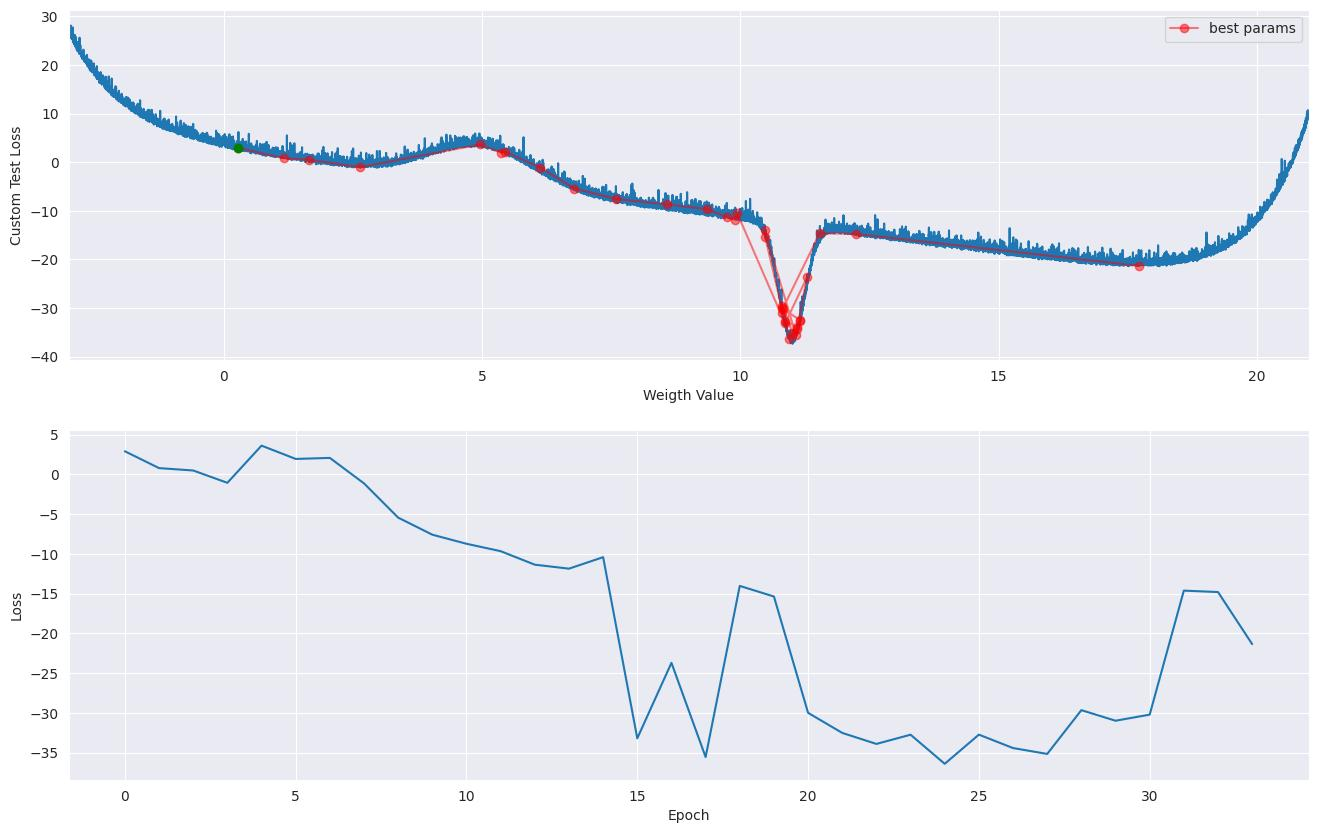

In [168]:
plt.figure(figsize=(16, 10))
learning_rate=tf.keras.optimizers.schedules.CosineDecayRestarts(best_params['lr'],2)
history = run(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=best_params['beta_1'],
                                                 beta_2=best_params['beta_2'],epsilon=best_params['epsilon']),seed=best_params['seed'],loss_func=custom_loss_tf2)
print(best_params)
print(history.history['loss'][-1])
plt.subplot(2,1,1)
plt.plot(x,y)
plt.plot(history.history['weight'],history.history['loss'],c='r',marker='o',label='best params'%(best_params),alpha=0.5)
plt.plot(history.history['weight'][0],history.history['loss'][0],c='g',marker='o')
plt.plot(history.history['weight'][-1],history.history['loss'][-1],c='y',marker='o')
plt.xlim([np.min(x),np.max(x)])
plt.xlabel('Weigth Value')
plt.ylabel('Custom Test Loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
#plt.ylim([np.min(y),np.max(y)])
plt.ylabel("Loss")
plt.xlabel("Epoch")